### Import libraries

In [1]:
import os
import sys

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# import own modules
sys.path.append(
    os.path.join("..", "..")
)  # Adds higher directory to python modules path.
from scripts import preprocessing as pp
from scripts import evaluate_models as em

# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle"
)

---
## Preparations

### Load the CSV into a Dataframe

- load csv (or calculate again if not in data folder)
- update index=id
- drop useless columns
- find numerical & object columns

In [2]:
# path to csv file
path_df = os.path.join("..", "..", "data", "df_deep_sam.csv")

# get features
df = pd.read_csv(path_df)

# set id as index
df = df.set_index("id", drop=True)

# drop first batch of useless variables
df = df.drop(columns=["img", "sp_idx"])
df = df.drop(columns=[col for col in df.columns if "_obj" in col])
df = df.drop(columns=[col for col in df.columns if "sam_sal_" in col])

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

 -> dataframe has 7598 instances and 34 columns
 -> there are 34 numerical columns
 -> there are 0 categoricals columns


### First, drop instances & features

- unusual long fixation durations are identified as outliers and dropped
  - drop if "dur > 5000 ms"
- drop `sal_first_above_0.75*max_rank` & `sal_first_above_0.9*max_rank` since this features consists of mainly (33% / 61%) outlier values
  - outliers are coded as "20" 


In [3]:
# processing
df = df[df["sp_fix_duration_ms_total"] <= 5000]
df = df.drop(columns=["dg_sal_first_above_0.75*max_rank", "dg_sal_first_above_0.9*max_rank"])

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

 -> dataframe has 7217 instances and 32 columns
 -> there are 32 numerical columns
 -> there are 0 categoricals columns


### Checking for highly correlated columns
think after running this lines, which column to additionally drop

Correlation between sp_fix_duration_ms_total and dg_sal_weighted_duration_sum is 0.828
Correlation between sp_fix_duration_ms_mean and dg_sal_weighted_duration_mean is 0.815
Correlation between obj_n_fix_face and obj_t_abs_on_face is 0.822
Correlation between obj_n_fix_face and obj_t_rel_on_face is 0.801
Correlation between obj_n_fix_inanimate and obj_t_abs_on_inanimate is 0.868
Correlation between obj_n_fix_inanimate and obj_t_rel_on_inanimate is 0.841
Correlation between obj_n_fix_background and obj_t_abs_on_background is 0.84
Correlation between obj_n_fix_background and obj_t_rel_on_background is 0.804


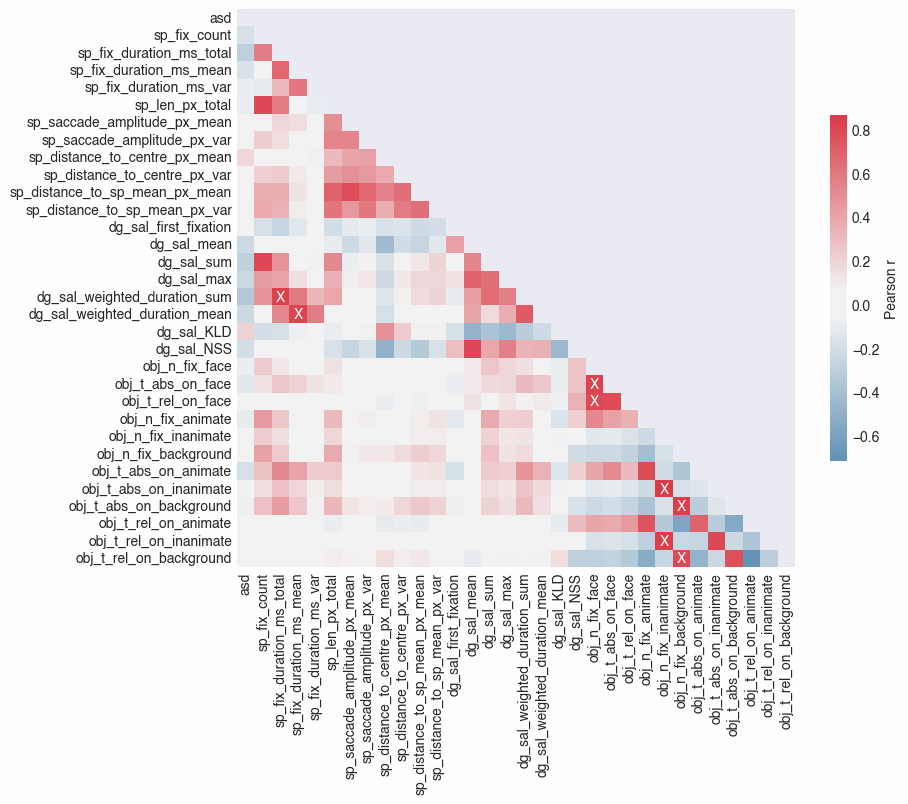

In [4]:
# check for correlations
pp.check_correlations(df[num_cols], thresh=0.8)

### further processing of correlating features
- `sp_fix_duration_ms_total` & `sp_fix_duration_ms_mean`
  - keep the `saliency weighted` version of both fixation duration measures
- `obj_n_fix_*`
  - keep the time measures of object recognition features

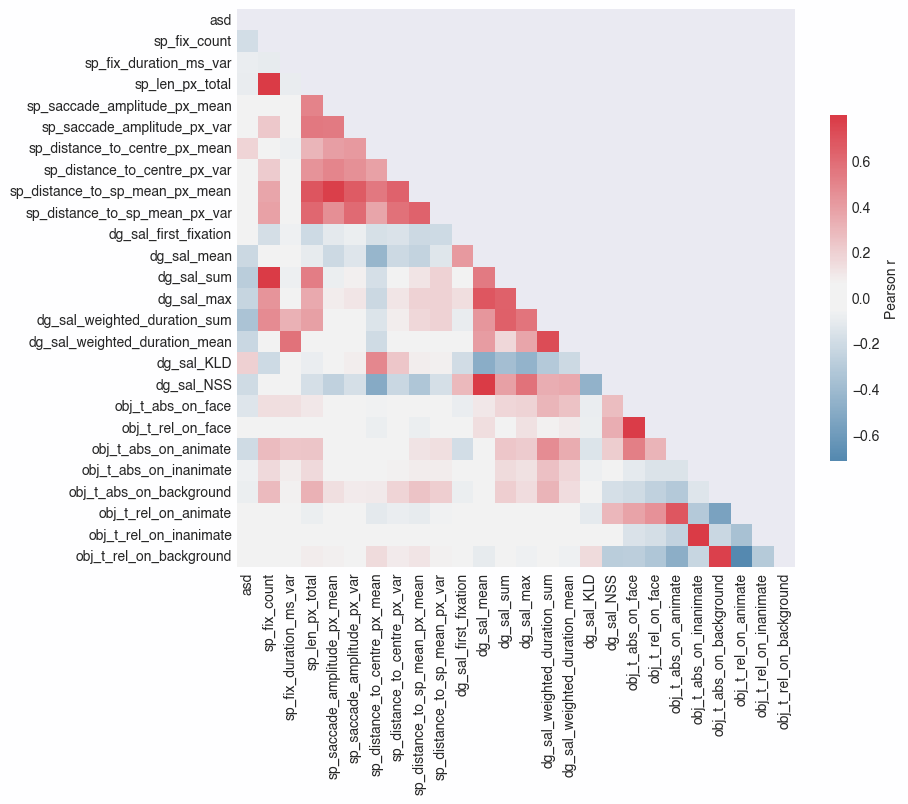

 -> dataframe has 7217 instances and 26 columns
 -> there are 26 numerical columns
 -> there are 0 categoricals columns


In [5]:
# processing
df = df.drop(
    columns=[
        "sp_fix_duration_ms_total",
        "sp_fix_duration_ms_mean",
        "obj_n_fix_face",
        "obj_n_fix_animate",
        "obj_n_fix_inanimate",
        "obj_n_fix_background",
    ]
)

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# check for correlations, again
pp.check_correlations(df[num_cols], thresh=0.8)

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

### Split into train & test sets

As soon as the dataset is in its final form, perform train-test-split with our own split function to have out 30-image-set always as our test set.

In [6]:
# prepare features and target
X = df
y = X.pop("asd")

# train-test-split
X_train, X_test, y_train, y_test = pp.split(X, y)

# print info
print(f"train-set has '{len(y_train)}' samples & '{X.shape[1]}' features")
print(f"test-set has '{len(y_test)}' samples - out of '{df.shape[0]}'")
print(f"  ~ {len(y_test) / df.shape[0] * 100:.2f}% of full dataset")

train-set has '6485' samples & '25' features
test-set has '732' samples - out of '7217'
  ~ 10.14% of full dataset


### Set variables

- define `metric`
- behavior for saving models as pickles
- defaults for model-objects

In [7]:
# metric
ftwo_scorer = make_scorer(fbeta_score, beta=2)

# model_folder
default_mdl_folder = os.path.join("..", "..", "models", "dev", "RF_Grid_dg")

# defaults
RSEED = 42
cv = 10
n_jobs = -1
verbose = 1

---
## Model - Preparations

###  Pipelines for each Model

In [8]:
# Random Forest: no scaling / no encoding
rf_pipeline = Pipeline([("classifier", RandomForestClassifier())])

----
## Modeling

### Random Forest

I'll start with a broader grid, and manualy adapt hyperparameters until a model is found which does not overfit.

#### 1: Full Grid

In [9]:
# grid
param_grid_rf = {
    "classifier__max_depth": [5, 10, 20, 30, 50],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [1, 2, 5, 10, 20],
    "classifier__min_samples_split": [2, 5, 10, 20, 50, 100],
    "classifier__n_estimators": [100, 200, 300, 400],
}

# Create GridSearchCV object & fit it
grid_search_rf_v1 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v1_full.pickle"

# fit or load
grid_search_rf_v1 = em.fit_or_load(
    grid_search_rf_v1, X_train, y_train, model_name, folder=default_mdl_folder
)

 -> model loaded from: '../../models/dev/RF_Grid_dg/RF_grid_v1_full.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.808     0.813     0.810      3252
           1      0.810     0.805     0.808      3233

    accuracy                          0.809      6485
   macro avg      0.809     0.809     0.809      6485
weighted avg      0.809     0.809     0.809      6485

f(0.5)-score: 0.809
f(2.0)-score: 0.806

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.693     0.744     0.718       371
           1      0.716     0.662     0.688       361

    accuracy                          0.704       732
   macro avg      0.705     0.703     0.703       732
weighted avg      0.704     0.704     0.703       732

f(0.5)-score: 0.704
f(2.0)-score: 0.672



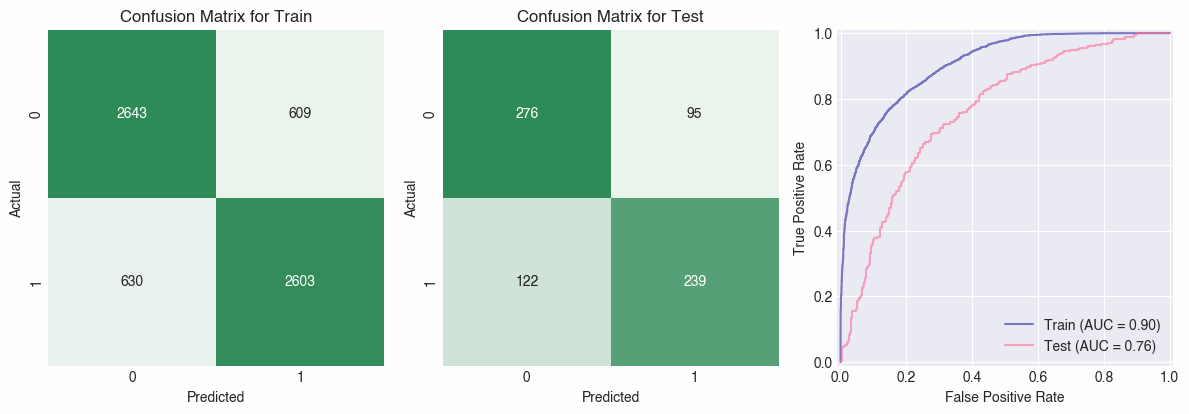

In [10]:
# predict & proba
pred_test = grid_search_rf_v1.predict(X_test)
proba_test = grid_search_rf_v1.predict_proba(X_test)

pred_train = grid_search_rf_v1.predict(X_train)
proba_train = grid_search_rf_v1.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [11]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v1)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=30, min_samples_leaf=2,
                                        min_samples_split=50,
                                        n_estimators=300))])

 ----- best parameter: -----
{'classifier__max_depth': 30,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 50,
 'classifier__n_estimators': 300}

 ----- RandomForestClassifier -----
   has on average 380 nodes
   has on average a maximum depth of 20



---

#### 2: prune "max_depth" & "min_sample_leafs"

In [12]:
# grid
param_grid_rf = {
    "classifier__max_depth": [5, 10, 20],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [5, 10, 20],
    "classifier__min_samples_split": [2, 5, 10, 20, 50, 100],
    "classifier__n_estimators": [200, 300, 400],
}

# Create GridSearchCV object & fit it
grid_search_rf_v2 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v2_pruning.pickle"

# fit or load
grid_search_rf_v2 = em.fit_or_load(
    grid_search_rf_v2, X_train, y_train, model_name, folder=default_mdl_folder
)

 -> model loaded from: '../../models/dev/RF_Grid_dg/RF_grid_v2_pruning.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.921     0.931     0.926      3252
           1      0.930     0.920     0.925      3233

    accuracy                          0.926      6485
   macro avg      0.926     0.926     0.926      6485
weighted avg      0.926     0.926     0.926      6485

f(0.5)-score: 0.928
f(2.0)-score: 0.922

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.698     0.741     0.719       371
           1      0.716     0.670     0.692       361

    accuracy                          0.706       732
   macro avg      0.707     0.706     0.706       732
weighted avg      0.707     0.706     0.706       732

f(0.5)-score: 0.706
f(2.0)-score: 0.679



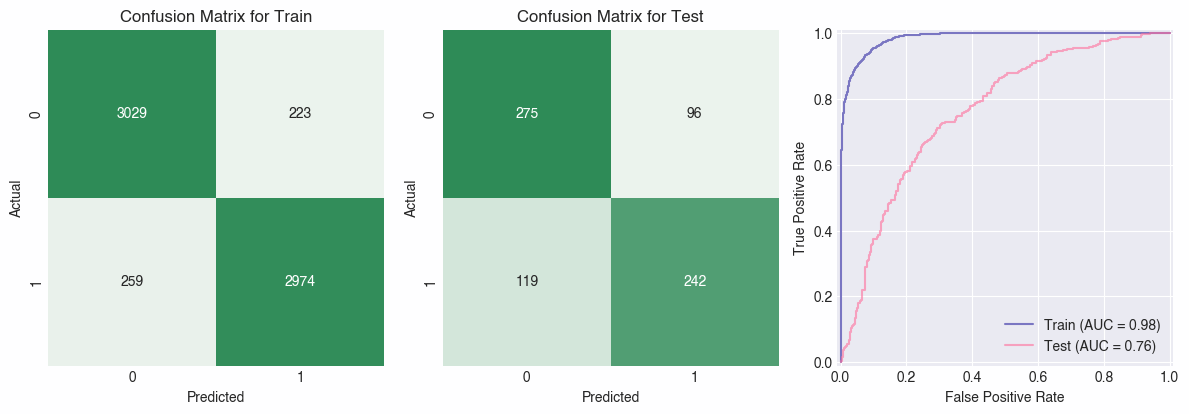

In [13]:
# predict & proba
pred_test = grid_search_rf_v2.predict(X_test)
proba_test = grid_search_rf_v2.predict_proba(X_test)

pred_train = grid_search_rf_v2.predict(X_train)
proba_train = grid_search_rf_v2.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [14]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v2)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=5,
                                        min_samples_split=5,
                                        n_estimators=400))])

 ----- best parameter: -----
{'classifier__max_depth': 20,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 5,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 400}

 ----- RandomForestClassifier -----
   has on average 1031 nodes
   has on average a maximum depth of 19



---

#### 3: pruning "min_samples_split" & "max_depth"

In [15]:
# grid
param_grid_rf = {
    "classifier__max_depth": [5, 10, 15],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [5, 10, 20],
    "classifier__min_samples_split": [10, 20, 50],
    "classifier__n_estimators": [200, 300, 400],
}

# Create GridSearchCV object & fit it
grid_search_rf_v3 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v3_pruning.pickle"

# fit or load
grid_search_rf_v3 = em.fit_or_load(
    grid_search_rf_v3, X_train, y_train, model_name, folder=default_mdl_folder
)

 -> model loaded from: '../../models/dev/RF_Grid_dg/RF_grid_v3_pruning.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.793     0.796     0.795      3252
           1      0.794     0.791     0.793      3233

    accuracy                          0.794      6485
   macro avg      0.794     0.794     0.794      6485
weighted avg      0.794     0.794     0.794      6485

f(0.5)-score: 0.794
f(2.0)-score: 0.792

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.701     0.744     0.722       371
           1      0.719     0.673     0.695       361

    accuracy                          0.709       732
   macro avg      0.710     0.709     0.708       732
weighted avg      0.710     0.709     0.709       732

f(0.5)-score: 0.709
f(2.0)-score: 0.682



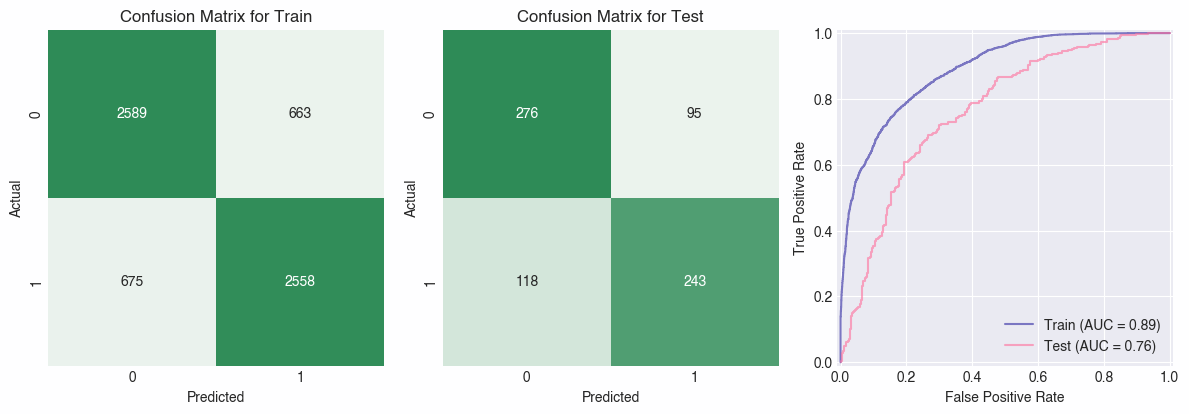

In [16]:
# predict & proba
pred_test = grid_search_rf_v3.predict(X_test)
proba_test = grid_search_rf_v3.predict_proba(X_test)

pred_train = grid_search_rf_v3.predict(X_train)
proba_train = grid_search_rf_v3.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [17]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v3)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=15, min_samples_leaf=5,
                                        min_samples_split=50,
                                        n_estimators=200))])

 ----- best parameter: -----
{'classifier__max_depth': 15,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 5,
 'classifier__min_samples_split': 50,
 'classifier__n_estimators': 200}

 ----- RandomForestClassifier -----
   has on average 325 nodes
   has on average a maximum depth of 14



---

#### 4: more pruning: "max_depth" & "min_samples_leaf" & "min_samples_split"

In [18]:
# grid
param_grid_rf = {
    "classifier__max_depth": [8, 10, 12],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [8, 12, 16],
    "classifier__min_samples_split": [30, 40, 50],
    "classifier__n_estimators": [150, 200, 250],
}

# Create GridSeardchCV object & fit it
grid_search_rf_v4 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v4_pruning.pickle"

# fit or load
grid_search_rf_v4 = em.fit_or_load(
    grid_search_rf_v4, X_train, y_train, model_name, folder=default_mdl_folder
)

 -> model loaded from: '../../models/dev/RF_Grid_dg/RF_grid_v4_pruning.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.787     0.794     0.791      3252
           1      0.791     0.784     0.788      3233

    accuracy                          0.789      6485
   macro avg      0.789     0.789     0.789      6485
weighted avg      0.789     0.789     0.789      6485

f(0.5)-score: 0.790
f(2.0)-score: 0.786

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.690     0.739     0.714       371
           1      0.710     0.659     0.684       361

    accuracy                          0.699       732
   macro avg      0.700     0.699     0.699       732
weighted avg      0.700     0.699     0.699       732

f(0.5)-score: 0.700
f(2.0)-score: 0.669



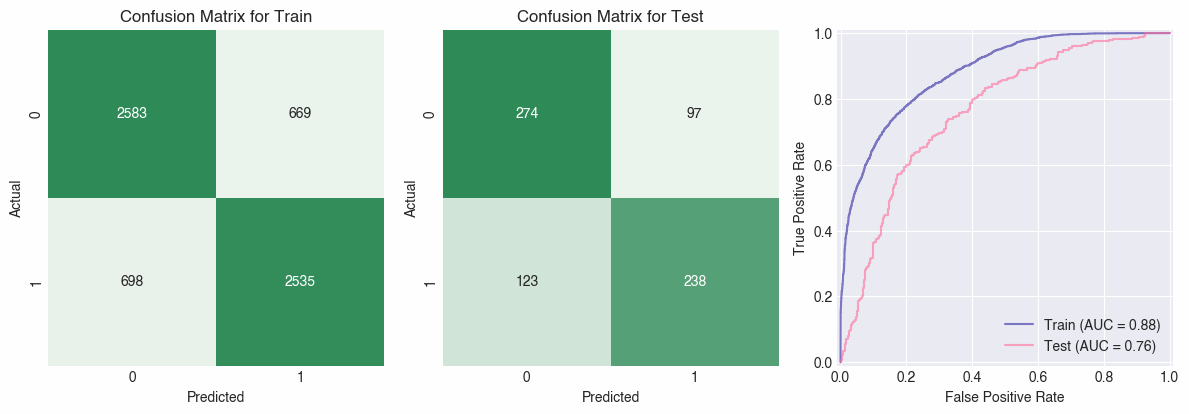

In [19]:
# predict & proba
pred_test = grid_search_rf_v4.predict(X_test)
proba_test = grid_search_rf_v4.predict_proba(X_test)

pred_train = grid_search_rf_v4.predict(X_train)
proba_train = grid_search_rf_v4.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [20]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v4)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=12, min_samples_leaf=8,
                                        min_samples_split=40,
                                        n_estimators=150))])

 ----- best parameter: -----
{'classifier__max_depth': 12,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 8,
 'classifier__min_samples_split': 40,
 'classifier__n_estimators': 150}

 ----- RandomForestClassifier -----
   has on average 317 nodes
   has on average a maximum depth of 12



---

#### 5: finetuning I

In [21]:
# grid
param_grid_rf = {
    "classifier__max_depth": [10, 11],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [9, 10, 11],
    "classifier__min_samples_split": [33, 36],
    "classifier__n_estimators": [150, 200],
}

# Create GridSeardchCV object & fit it
grid_search_rf_v5 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v5_pruning.pickle"

# fit or load
grid_search_rf_v5 = em.fit_or_load(
    grid_search_rf_v5, X_train, y_train, model_name, folder=default_mdl_folder
)

 -> model loaded from: '../../models/dev/RF_Grid_dg/RF_grid_v5_pruning.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.776     0.784     0.780      3252
           1      0.781     0.773     0.777      3233

    accuracy                          0.779      6485
   macro avg      0.779     0.779     0.779      6485
weighted avg      0.779     0.779     0.779      6485

f(0.5)-score: 0.779
f(2.0)-score: 0.774

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.698     0.749     0.723       371
           1      0.722     0.668     0.694       361

    accuracy                          0.709       732
   macro avg      0.710     0.708     0.708       732
weighted avg      0.710     0.709     0.708       732

f(0.5)-score: 0.710
f(2.0)-score: 0.678



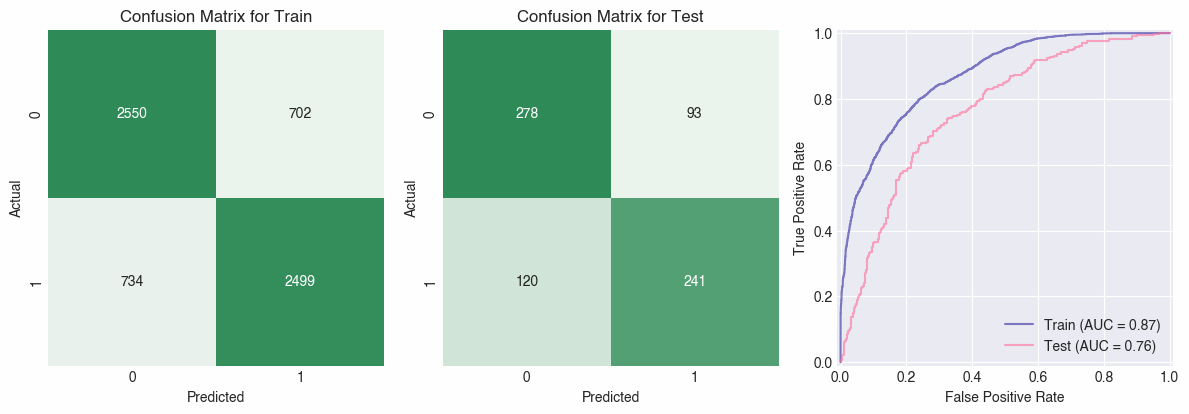

In [22]:
# predict & proba
pred_test = grid_search_rf_v5.predict(X_test)
proba_test = grid_search_rf_v5.predict_proba(X_test)

pred_train = grid_search_rf_v5.predict(X_train)
proba_train = grid_search_rf_v5.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [23]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v5)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                                        min_samples_leaf=11,
                                        min_samples_split=36,
                                        n_estimators=200))])

 ----- best parameter: -----
{'classifier__max_depth': 11,
 'classifier__max_features': 'log2',
 'classifier__min_samples_leaf': 11,
 'classifier__min_samples_split': 36,
 'classifier__n_estimators': 200}

 ----- RandomForestClassifier -----
   has on average 307 nodes
   has on average a maximum depth of 11



---

#### 6: finetuning II

In [24]:
# grid
param_grid_rf = {
    "classifier__max_depth": [9, 10],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [9, 10, 11],
    "classifier__min_samples_split": [33, 36, 39],
    "classifier__n_estimators": [100, 150, 200],
}

# Create GridSeardchCV object & fit it
grid_search_rf_v6 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v6_pruning.pickle"

# fit or load
grid_search_rf_v6 = em.fit_or_load(
    grid_search_rf_v6, X_train, y_train, model_name, folder=default_mdl_folder
)

 -> model loaded from: '../../models/dev/RF_Grid_dg/RF_grid_v6_pruning.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.772     0.780     0.776      3252
           1      0.776     0.768     0.772      3233

    accuracy                          0.774      6485
   macro avg      0.774     0.774     0.774      6485
weighted avg      0.774     0.774     0.774      6485

f(0.5)-score: 0.775
f(2.0)-score: 0.770

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.696     0.747     0.720       371
           1      0.719     0.665     0.691       361

    accuracy                          0.706       732
   macro avg      0.707     0.706     0.706       732
weighted avg      0.707     0.706     0.706       732

f(0.5)-score: 0.707
f(2.0)-score: 0.675



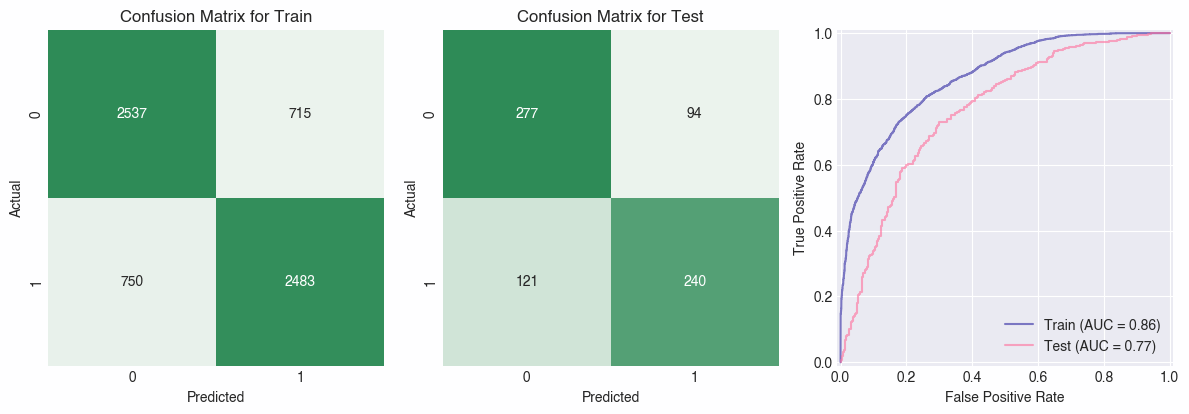

In [25]:
# predict & proba
pred_test = grid_search_rf_v6.predict(X_test)
proba_test = grid_search_rf_v6.predict_proba(X_test)

pred_train = grid_search_rf_v6.predict(X_train)
proba_train = grid_search_rf_v6.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [26]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v6)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=10,
                                        min_samples_split=36,
                                        n_estimators=200))])

 ----- best parameter: -----
{'classifier__max_depth': 10,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 10,
 'classifier__min_samples_split': 36,
 'classifier__n_estimators': 200}

 ----- RandomForestClassifier -----
   has on average 272 nodes
   has on average a maximum depth of 10



---

#### 7: finetuning III

In [27]:
# grid
param_grid_rf = {
    "classifier__max_depth": [8, 9],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [9, 10, 11],
    "classifier__min_samples_split": [33, 36, 39],
    "classifier__n_estimators": [80, 100, 120],
}

# Create GridSeardchCV object & fit it
grid_search_rf_v7 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v7_pruning.pickle"

# fit or load
grid_search_rf_v7 = em.fit_or_load(
    grid_search_rf_v7, X_train, y_train, model_name, folder=default_mdl_folder
)

 -> model loaded from: '../../models/dev/RF_Grid_dg/RF_grid_v7_pruning.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.758     0.765     0.762      3252
           1      0.762     0.755     0.758      3233

    accuracy                          0.760      6485
   macro avg      0.760     0.760     0.760      6485
weighted avg      0.760     0.760     0.760      6485

f(0.5)-score: 0.760
f(2.0)-score: 0.756

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.704     0.749     0.726       371
           1      0.724     0.676     0.699       361

    accuracy                          0.713       732
   macro avg      0.714     0.713     0.712       732
weighted avg      0.714     0.713     0.713       732

f(0.5)-score: 0.714
f(2.0)-score: 0.685



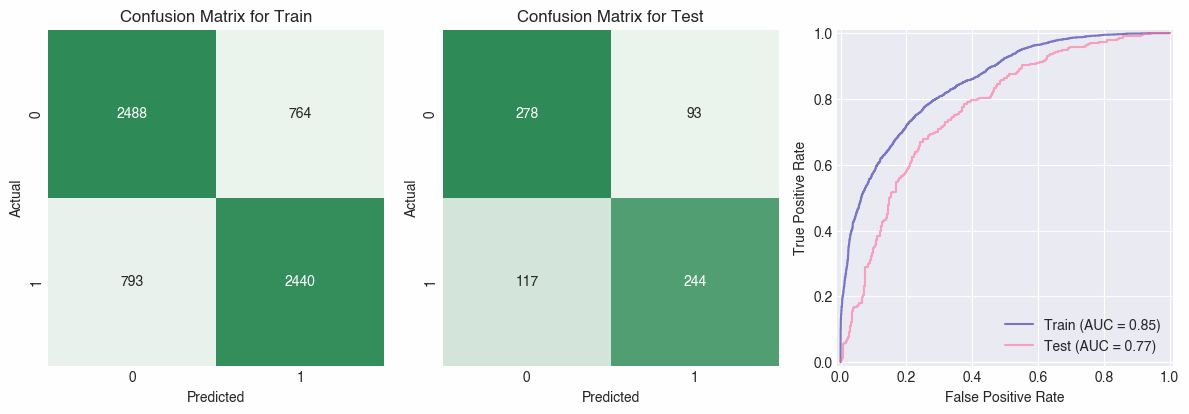

In [28]:
# predict & proba
pred_test = grid_search_rf_v7.predict(X_test)
proba_test = grid_search_rf_v7.predict_proba(X_test)

pred_train = grid_search_rf_v7.predict(X_train)
proba_train = grid_search_rf_v7.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [29]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v7)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=9, min_samples_leaf=9,
                                        min_samples_split=39,
                                        n_estimators=120))])

 ----- best parameter: -----
{'classifier__max_depth': 9,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 9,
 'classifier__min_samples_split': 39,
 'classifier__n_estimators': 120}

 ----- RandomForestClassifier -----
   has on average 217 nodes
   has on average a maximum depth of 9



---

#### 8: finetuning IV

In [30]:
# grid
param_grid_rf = {
    "classifier__max_depth": [8],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [30],
    "classifier__min_samples_split": [60],
    "classifier__n_estimators": [80, 85, 90],
}

# Create GridSeardchCV object & fit it
grid_search_rf_v8 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v8_pruning.pickle"

# fit or load
grid_search_rf_v8 = em.fit_or_load(
    grid_search_rf_v8, X_train, y_train, model_name, folder=default_mdl_folder
)

 -> model loaded from: '../../models/dev/RF_Grid_dg/RF_grid_v8_pruning.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.728     0.742     0.735      3252
           1      0.735     0.721     0.728      3233

    accuracy                          0.731      6485
   macro avg      0.731     0.731     0.731      6485
weighted avg      0.731     0.731     0.731      6485

f(0.5)-score: 0.732
f(2.0)-score: 0.724

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.694     0.757     0.724       371
           1      0.725     0.657     0.689       361

    accuracy                          0.708       732
   macro avg      0.709     0.707     0.707       732
weighted avg      0.709     0.708     0.707       732

f(0.5)-score: 0.710
f(2.0)-score: 0.669



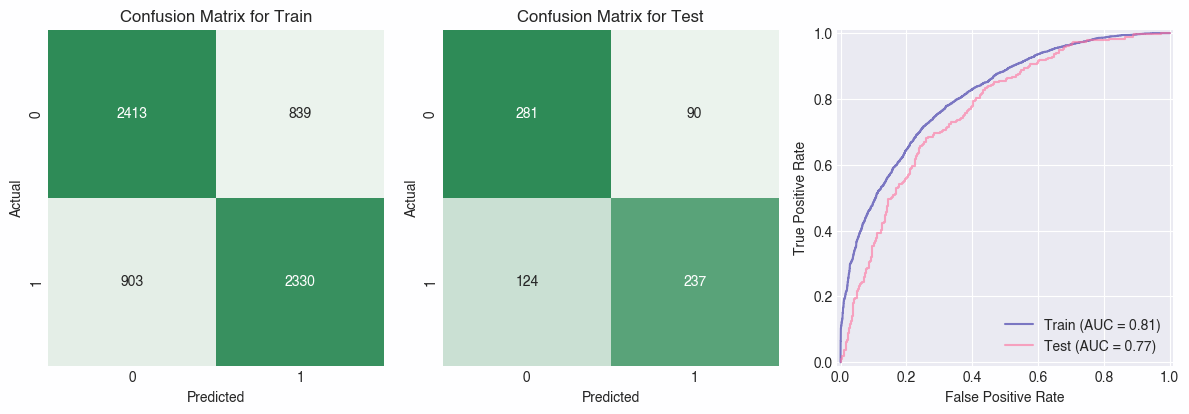

In [31]:
# predict & proba
pred_test = grid_search_rf_v8.predict(X_test)
proba_test = grid_search_rf_v8.predict_proba(X_test)

pred_train = grid_search_rf_v8.predict(X_train)
proba_train = grid_search_rf_v8.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [32]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v8)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=8, min_samples_leaf=30,
                                        min_samples_split=60,
                                        n_estimators=90))])

 ----- best parameter: -----
{'classifier__max_depth': 8,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 30,
 'classifier__min_samples_split': 60,
 'classifier__n_estimators': 90}

 ----- RandomForestClassifier -----
   has on average 144 nodes
   has on average a maximum depth of 8



---

#### 9: finetuning V

In [33]:
# grid
param_grid_rf = {
    "classifier__max_depth": [7],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [30],
    "classifier__min_samples_split": [60],
    "classifier__n_estimators": [75, 80, 85],
}

# Create GridSeardchCV object & fit it
grid_search_rf_v9 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# set file & folder name
model_name = "RF_grid_v9_pruning.pickle"

# fit or load
grid_search_rf_v9 = em.fit_or_load(
    grid_search_rf_v9, X_train, y_train, model_name, folder=default_mdl_folder
)

 -> model loaded from: '../../models/dev/RF_Grid_dg/RF_grid_v9_pruning.pickle'


-------------------- classification report for 'Train' --------------------


              precision    recall  f1-score   support

           0      0.714     0.733     0.724      3252
           1      0.724     0.705     0.715      3233

    accuracy                          0.719      6485
   macro avg      0.719     0.719     0.719      6485
weighted avg      0.719     0.719     0.719      6485

f(0.5)-score: 0.721
f(2.0)-score: 0.709

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.701     0.757     0.728       371
           1      0.728     0.668     0.697       361

    accuracy                          0.713       732
   macro avg      0.714     0.713     0.712       732
weighted avg      0.714     0.713     0.712       732

f(0.5)-score: 0.715
f(2.0)-score: 0.679



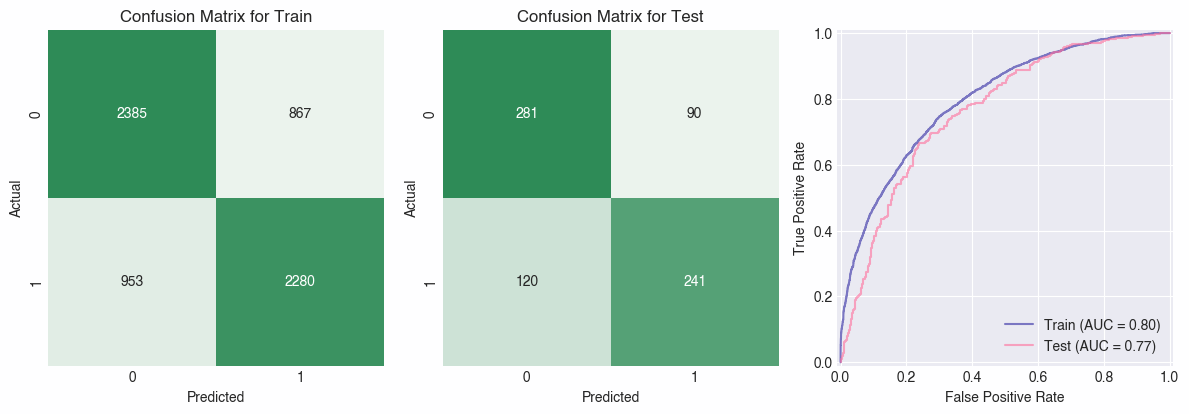

In [34]:
# predict & proba
pred_test = grid_search_rf_v9.predict(X_test)
proba_test = grid_search_rf_v9.predict_proba(X_test)

pred_train = grid_search_rf_v9.predict(X_train)
proba_train = grid_search_rf_v9.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [35]:
# Get the best parameters and best estimator
em.model_info(grid_search_rf_v9)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=7, min_samples_leaf=30,
                                        min_samples_split=60,
                                        n_estimators=75))])

 ----- best parameter: -----
{'classifier__max_depth': 7,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 30,
 'classifier__min_samples_split': 60,
 'classifier__n_estimators': 75}

 ----- RandomForestClassifier -----
   has on average 112 nodes
   has on average a maximum depth of 7



---

### error

#### compare models

30it [00:02, 12.16it/s]


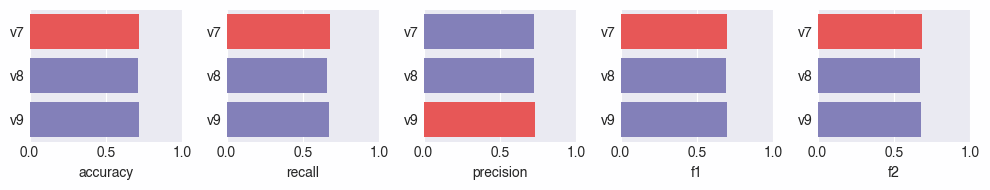

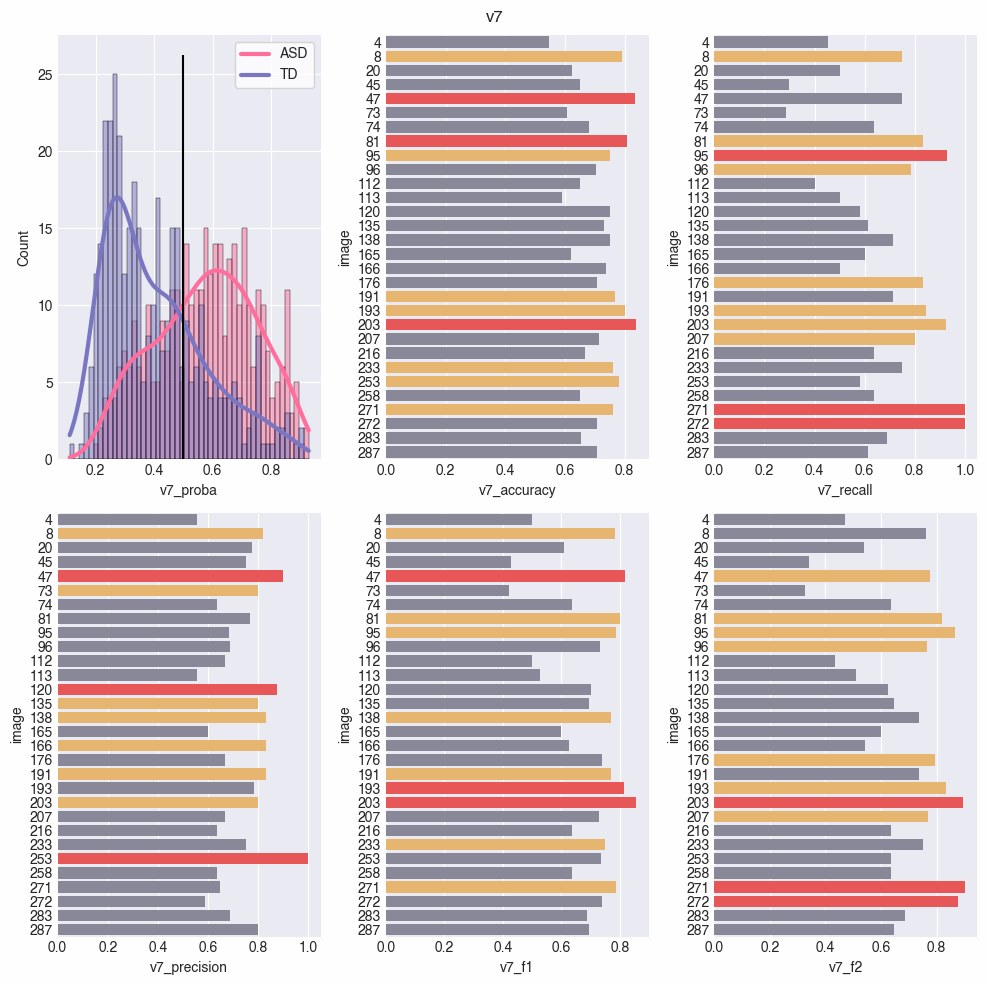

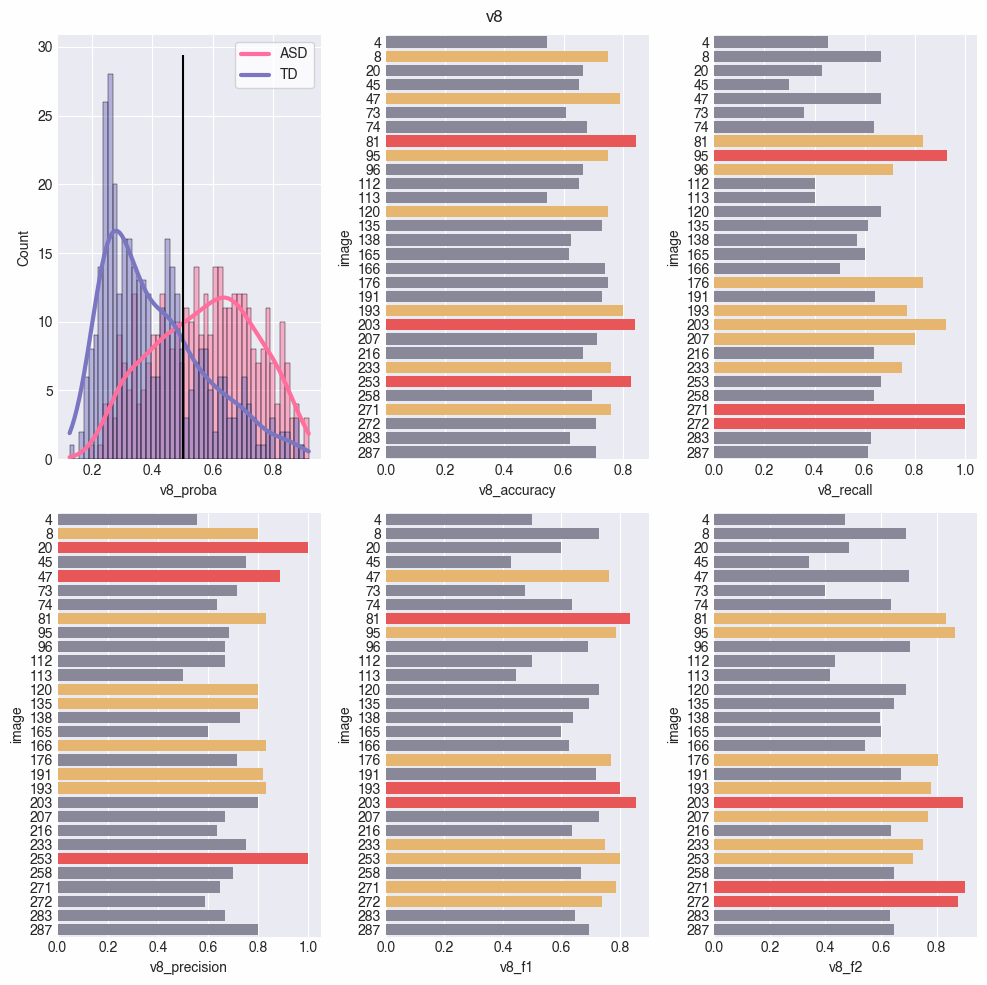

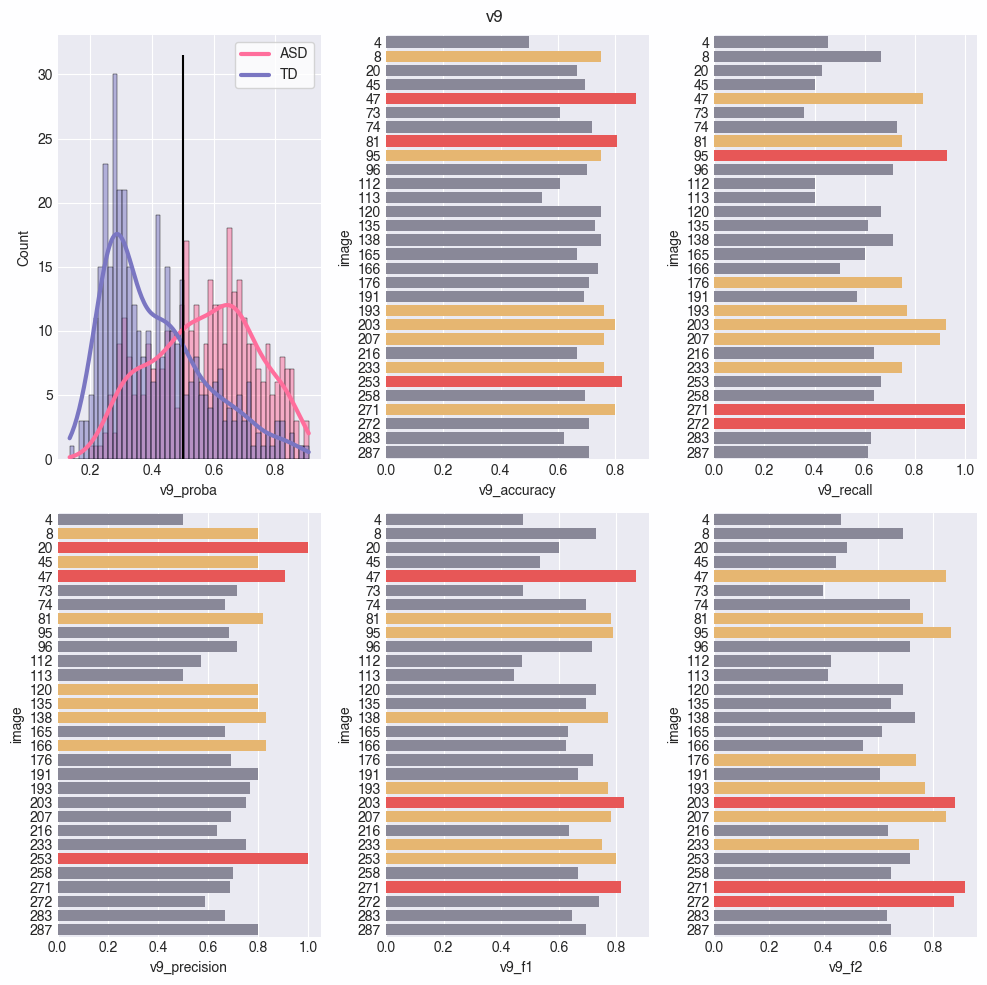

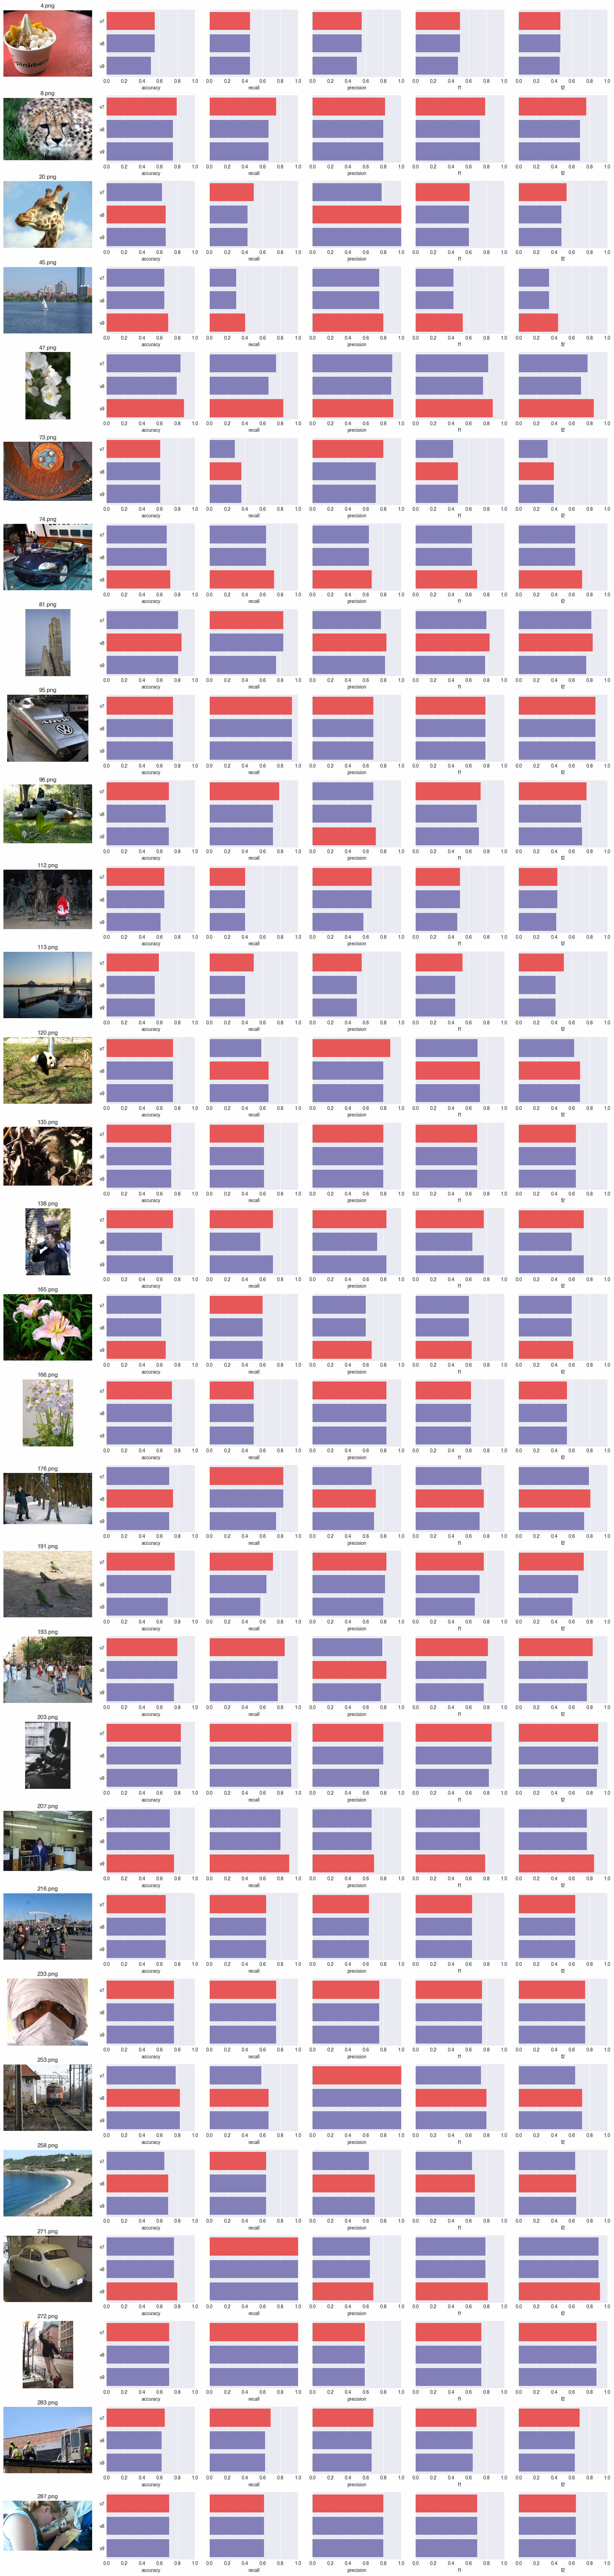

In [36]:
names = ["v7", "v8", "v9"]
inp = {
    "v7": [grid_search_rf_v7.predict(X_test), grid_search_rf_v7.predict_proba(X_test)],
    "v8": [grid_search_rf_v8.predict(X_test), grid_search_rf_v8.predict_proba(X_test)],
    "v9": [grid_search_rf_v9.predict(X_test), grid_search_rf_v9.predict_proba(X_test)],
}
em.error_compare_models(inp, y_test)
